In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kongaevans/speaker-recognition-dataset")

print("Path to dataset files:", path)

100%|██████████| 231M/231M [00:01<00:00, 125MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kongaevans/speaker-recognition-dataset/versions/1


In [2]:
# Install required packages
!pip install kagglehub librosa soundfile tensorflow scikit-learn --quiet

import kagglehub
import os
import zipfile
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# ----------------------------
# 1. Download the Dataset with Kagglehub
# ----------------------------
dataset_path = kagglehub.dataset_download("kongaevans/speaker-recognition-dataset")
print("Downloaded dataset path:", dataset_path)

# Check if the downloaded path is a directory or a zip file.
if os.path.isdir(dataset_path):
    print("Dataset path is a directory. Using it directly as the extract folder.")
    extract_folder = dataset_path
else:
    extract_folder = "/content/speaker_dataset"
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print("Extracted dataset to:", extract_folder)

# Set the base directory. Adjust if the folder structure is different.
base_dir = os.path.join(extract_folder, "16000_pcm_speeches")
print("Dataset base directory:", base_dir)

# ----------------------------
# 2. Prepare the Data: Gather Files and Split Dataset
# ----------------------------
# List speaker directories (excluding folders like "_background_noise_")
speakers = [d for d in os.listdir(base_dir)
            if os.path.isdir(os.path.join(base_dir, d)) and not d.startswith('_')]
print("Speakers found:", speakers)

audio_files = []
labels = []
for speaker in speakers:
    speaker_dir = os.path.join(base_dir, speaker)
    for file in os.listdir(speaker_dir):
        if file.endswith('.wav'):  # Adjust the extension if needed
            audio_files.append(os.path.join(speaker_dir, file))
            labels.append(speaker)
print("Total audio files:", len(audio_files))

# Create mapping from speaker names to numeric indices
unique_speakers = sorted(list(set(labels)))
speaker_to_idx = {speaker: i for i, speaker in enumerate(unique_speakers)}
num_speakers = len(unique_speakers)
numeric_labels = [speaker_to_idx[label] for label in labels]
print("Unique speakers (and indices):", speaker_to_idx)

# Split the dataset: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(audio_files, numeric_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))
print("Test samples:", len(X_test))

# ----------------------------
# 3. Feature Extraction and TensorFlow Dataset Creation
# ----------------------------
def extract_features(file_path, sr=16000, n_mfcc=40, max_len=128):
    # Load the audio file with a 16kHz sampling rate
    y, _ = librosa.load(file_path, sr=sr)
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    # Pad or truncate MFCC features along the time axis
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc

def gen_dataset(file_paths, labels, batch_size=16, n_mfcc=40, max_len=128):
    def generator():
        for file_path, label in zip(file_paths, labels):
            mfcc = extract_features(file_path, n_mfcc=n_mfcc, max_len=max_len)
            mfcc = np.expand_dims(mfcc, axis=-1)  # Shape: (n_mfcc, max_len, 1)
            yield mfcc, label
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.float32, tf.int32),
        output_shapes=((n_mfcc, max_len, 1), ())
    )
    dataset = dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Parameters for dataset creation
batch_size = 16
n_mfcc = 40
max_len = 128

train_dataset = gen_dataset(X_train, y_train, batch_size, n_mfcc, max_len)
val_dataset   = gen_dataset(X_val, y_val, batch_size, n_mfcc, max_len)
test_dataset  = gen_dataset(X_test, y_test, batch_size, n_mfcc, max_len)

# ----------------------------
# 4. Build and Compile the Speaker Recognition Model
# ----------------------------
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(n_mfcc, max_len, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_speakers, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# ----------------------------
# 5. Train the Model
# ----------------------------
epochs = 20  # Adjust the number of epochs as needed
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)

# ----------------------------
# 6. Evaluate the Model
# ----------------------------
test_loss, test_acc = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


Downloaded dataset path: /root/.cache/kagglehub/datasets/kongaevans/speaker-recognition-dataset/versions/1
Dataset path is a directory. Using it directly as the extract folder.
Dataset base directory: /root/.cache/kagglehub/datasets/kongaevans/speaker-recognition-dataset/versions/1/16000_pcm_speeches
Speakers found: ['Magaret_Tarcher', 'Julia_Gillard', 'other', 'Nelson_Mandela', 'Benjamin_Netanyau', 'Jens_Stoltenberg']
Total audio files: 7503
Unique speakers (and indices): {'Benjamin_Netanyau': 0, 'Jens_Stoltenberg': 1, 'Julia_Gillard': 2, 'Magaret_Tarcher': 3, 'Nelson_Mandela': 4, 'other': 5}
Training samples: 5252
Validation samples: 1125
Test samples: 1126


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 38, 126, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 19, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 17, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 30, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 28, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 14, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5376)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         688,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 781,702 (2.98 MB)

 Trainable params: 781,702 (2.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
    328/Unknown 116s 289ms/step - accuracy: 0.7384 - loss: 0.7896

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


329/329 ━━━━━━━━━━━━━━━━━━━━ 129s 328ms/step - accuracy: 0.7392 - loss: 0.7870 - val_accuracy: 0.9822 - val_loss: 0.0615
Epoch 2/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 123s 327ms/step - accuracy: 0.9783 - loss: 0.0642 - val_accuracy: 0.9893 - val_loss: 0.0300
Epoch 3/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 144s 334ms/step - accuracy: 0.9794 - loss: 0.0607 - val_accuracy: 0.9751 - val_loss: 0.0661
Epoch 4/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 110s 331ms/step - accuracy: 0.9859 - loss: 0.0408 - val_accuracy: 0.9867 - val_loss: 0.0516
Epoch 5/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 142s 332ms/step - accuracy: 0.9844 - loss: 0.0395 - val_accuracy: 0.9884 - val_loss: 0.0444
Epoch 6/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 139s 323ms/step - accuracy: 0.9897 - loss: 0.0351 - val_accuracy: 0.9804 - val_loss: 0.0788
Epoch 7/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 110s 332ms/step - accuracy: 0.9896 - loss: 0.0305 - val_accuracy: 0.9849 - val_loss: 0.0471
Epoch 8/20
329/329 ━━━━━━━━━━━━━━━━━━━━ 109s 325ms/step - accuracy: 0.9903 - loss: 0.03

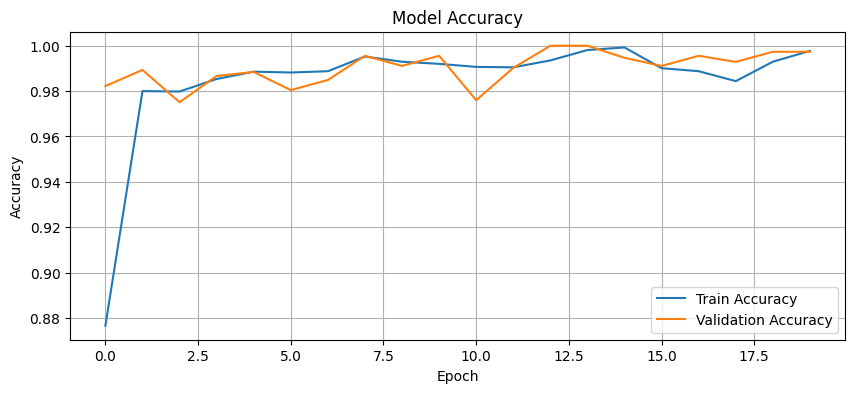

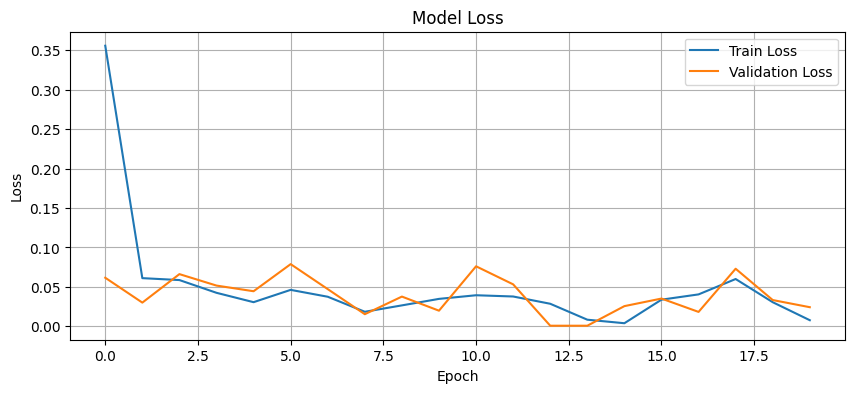

In [5]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import IPython.display as ipd
import numpy as np

# Map back speaker indices to names
idx_to_speaker = {v: k for k, v in speaker_to_idx.items()}

# Last 10 test samples
SAMPLES_TO_DISPLAY = 10
sample_rate = 16000

for i in range(-SAMPLES_TO_DISPLAY, 0):
    file_path = X_test[i]
    true_label = y_test[i]

    # Extract features and predict
    mfcc = extract_features(file_path)
    mfcc = np.expand_dims(mfcc, axis=-1)         # (40, 128, 1)
    mfcc = np.expand_dims(mfcc, axis=0)          # (1, 40, 128, 1)
    prediction = model.predict(mfcc)
    pred_label = np.argmax(prediction)

    # Convert to speaker names
    actual_name = idx_to_speaker[true_label]
    predicted_name = idx_to_speaker[pred_label]

    # Color display
    color_code = 32 if true_label == pred_label else 31  # green or red
    print(f"Speaker: \033[1m{actual_name}\033[0m  Predicted: \033[1;{color_code}m{predicted_name}\033[0m")

    # Display audio
    ipd.display(ipd.Audio(file_path, rate=sample_rate))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Speaker: Magaret_Tarcher  Predicted: Magaret_Tarcher


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Speaker: Magaret_Tarcher  Predicted: Magaret_Tarcher


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Speaker: Magaret_Tarcher  Predicted: Magaret_Tarcher


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Speaker: Julia_Gillard  Predicted: Julia_Gillard


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Speaker: Jens_Stoltenberg  Predicted: Jens_Stoltenberg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Speaker: Magaret_Tarcher  Predicted: Magaret_Tarcher


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Speaker: Magaret_Tarcher  Predicted: Magaret_Tarcher


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Speaker: Julia_Gillard  Predicted: Julia_Gillard


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Speaker: Julia_Gillard  Predicted: Julia_Gillard


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Speaker: Magaret_Tarcher  Predicted: Magaret_Tarcher
